## Setup

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
#Import the visualization libraries
import seaborn as sn
import matplotlib.pyplot as plt

## Preparing Data

In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/Data Skripsi/data-firebase/raw-data/newestdata.csv')
dataframe.drop(['z_count', 'Ts', '_key', 'bitSoilSensor1', 'bitSoilSensor2', 'voltageSoilSense1', 'voltageSoilSense2', 'week', 'percentageSoilSensor1'], axis=1, inplace=True)
display(dataframe.head(5))
original_dataframe = dataframe.copy(deep=True)

,percentageSoilSensor2,roomHumidity,roomTemperature,status
0,82,99.6,30.0,0.0
1,83,98.1,30.0,0.0
2,81,98.9,30.2,0.0
3,82,98.7,30.5,0.0
4,84,97.5,31.0,0.0


In [ ]:
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
percentageSoilSensor2,9645.0,87.359461,12.633233,0.000000,83.0,92.0,94.0,100.0
roomHumidity,9645.0,96.723811,13.221639,-1.214748,99.3,99.9,99.9,99.9
roomTemperature,9645.0,28.977123,5.102066,-1.214748,26.7,28.4,32.0,38.3
status,9644.0,0.053712,0.225460,0.000000,0.0,0.0,0.0,1.0


In [ ]:
dataframe = dataframe[dataframe.roomHumidity > 0]
dataframe = dataframe[dataframe.roomTemperature > 0]

In [ ]:
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
percentageSoilSensor2,9486.0,87.322581,12.560008,0.0,83.0,92.0,94.0,100.0
roomHumidity,9486.0,98.365412,3.775445,68.6,99.7,99.9,99.9,99.9
roomTemperature,9486.0,29.483186,3.306166,24.1,26.8,28.5,32.1,38.3
status,9485.0,0.053980,0.225990,0.0,0.0,0.0,0.0,1.0


In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9486 entries, 0 to 9644
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   percentageSoilSensor2  9486 non-null   int64  
 1   roomHumidity           9486 non-null   float64
 2   roomTemperature        9486 non-null   float64
 3   status                 9485 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 370.5 KB


In [ ]:
dataframe.isnull().values.any()

True

In [ ]:
dataframe.isnull().sum()

percentageSoilSensor2    0
roomHumidity             0
roomTemperature          0
status                   1
dtype: int64

In [ ]:
dataframe = dataframe.dropna()

In [ ]:
dataframe.isnull().sum()

percentageSoilSensor2    0
roomHumidity             0
roomTemperature          0
status                   0
dtype: int64

###Changing status from float to int

In [ ]:
dataframe

,percentageSoilSensor2,roomHumidity,roomTemperature,status
0,82,99.6,30.0,0.0
1,83,98.1,30.0,0.0
2,81,98.9,30.2,0.0
3,82,98.7,30.5,0.0
4,84,97.5,31.0,0.0
...,...,...,...,...
9640,57,99.9,28.9,1.0
9641,57,99.9,28.9,1.0
9642,56,99.9,29.1,1.0
9643,57,99.9,29.6,1.0


In [ ]:
dataframe['status'] = dataframe['status'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dataframe.shape

(9485, 4)

In [ ]:
val_dataframe = dataframe.sample(frac=0.2)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 7588 samples for training and 1897 for validation


### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [ ]:
train_mean = train_dataframe.mean()
train_std = train_dataframe.std()

train_df = (train_dataframe - train_mean) / train_std
val_df = (val_dataframe - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

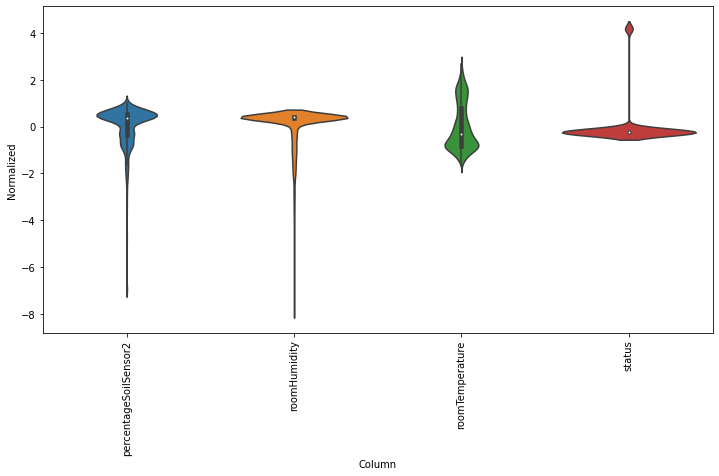

In [ ]:
df_std = (dataframe - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sn.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dataframe.keys(), rotation=90)

In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("status")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [ ]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'percentageSoilSensor2': <tf.Tensor: shape=(), dtype=int64, numpy=93>, 'roomHumidity': <tf.Tensor: shape=(), dtype=float64, numpy=99.9>, 'roomTemperature': <tf.Tensor: shape=(), dtype=float64, numpy=28.9>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
val_ds = val_ds.batch(16)

## Feature preprocessing with Keras layers

In [ ]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

## Build a model

In [ ]:
# percentageSoilSensor1 = keras.Input(shape = (1,), name='percentageSoilSensor1')
percentageSoilSensor2 = keras.Input(shape = (1,), name='percentageSoilSensor2')
roomHumidity = keras.Input(shape = (1,), name='roomHumidity')
roomTemperature = keras.Input(shape = (1,), name='roomTemperature')
all_inputs = [
              percentageSoilSensor2, roomHumidity, roomTemperature 
]

In [ ]:
# percentageSoilSensor1_encoded = encode_numerical_feature(percentageSoilSensor1, 'percentageSoilSensor1', train_ds)
percentageSoilSensor2_encoded = encode_numerical_feature(percentageSoilSensor2, 'percentageSoilSensor2', train_ds)
roomHumidity_encoded = encode_numerical_feature(roomHumidity, 'roomHumidity', train_ds)
roomTemperature_encoded = encode_numerical_feature(roomTemperature, 'roomTemperature', train_ds)
all_features = layers.concatenate(
    [
     percentageSoilSensor2_encoded, roomHumidity_encoded, roomTemperature_encoded
    ]
)

In [ ]:
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation= "relu")(x)
output = layers.Dense(1, activation="sigmoid")(x) 
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

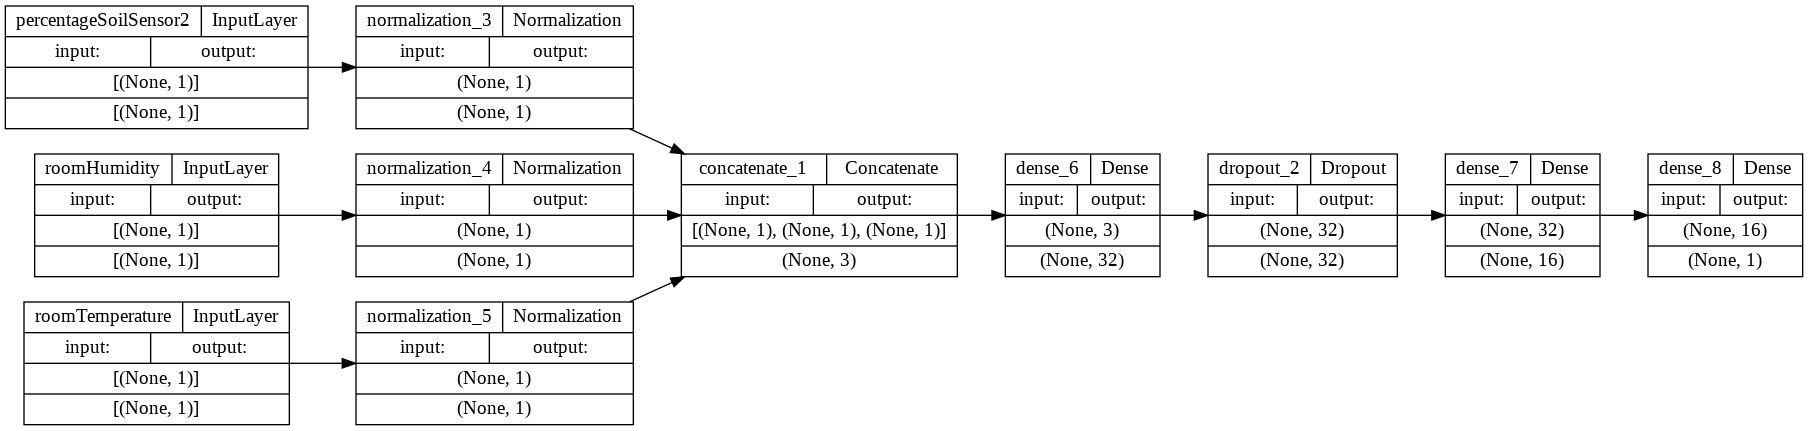

In [ ]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Train Model

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
475/475 [==============================] - 2s 3ms/step - loss: 0.2283 - accuracy: 0.9389 - val_loss: 0.1376 - val_accuracy: 0.9457
Epoch 2/50
475/475 [==============================] - 1s 3ms/step - loss: 0.1329 - accuracy: 0.9537 - val_loss: 0.1262 - val_accuracy: 0.9494
Epoch 3/50
475/475 [==============================] - 1s 3ms/step - loss: 0.1249 - accuracy: 0.9548 - val_loss: 0.1200 - val_accuracy: 0.9568
Epoch 4/50
475/475 [==============================] - 1s 3ms/step - loss: 0.1220 - accuracy: 0.9598 - val_loss: 0.1152 - val_accuracy: 0.9615
Epoch 5/50
475/475 [==============================] - 1s 3ms/step - loss: 0.1168 - accuracy: 0.9607 - val_loss: 0.1120 - val_accuracy: 0.9636
Epoch 6/50
475/475 [==============================] - 1s 3ms/step - loss: 0.1128 - accuracy: 0.9631 - val_loss: 0.1088 - val_accuracy: 0.9663
Epoch 7/50
475/475 [==============================] - 1s 3ms/step - loss: 0.1116 - accuracy: 0.9643 - val_loss: 0.1068 - val_accuracy: 0.9620
Epoch 

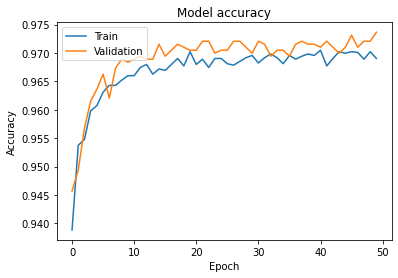

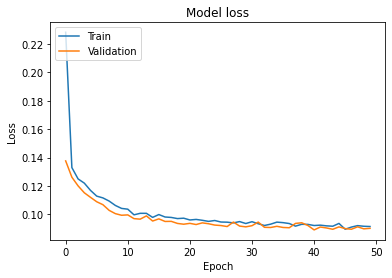

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss']
)
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
sample = {
    "percentageSoilSensor2": 50,
    "roomTemperature" : 29,
    "roomHumidity" : 99

}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular Percentage had a %.1f percent probability "
    "of getting Stepper Motor online, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular Percentage had a 51.1 percent probability of getting Stepper Motor online, as evaluated by our model.


In [ ]:
model.save('/content/drive/MyDrive/Data Skripsi/data-firebase/saved_model/water_status_v4_Dense_DNN_worsethan v3.h5') 